In [1]:
# Ref 1: https://apmonitor.com/do/index.php/Main/TCLabE
# Ref 2: https://apmonitor.com/do/index.php/Main/TCLabG

import tclab
from tclab import setup
from tclab import Historian, Plotter, clock
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from gekko import GEKKO

In [2]:
# Create TCLab model
T10 = 20.95
T20 = 20.95

In [3]:
# Run time in minutes
run_time = 21.0

# Number of cycles with 3 second intervals
loops = int(60.0*run_time)
tm = np.zeros(loops)

In [4]:
# Temperature (K)
# Esta celda es la que tiene los datos para entrenamiento
Tsp1 = np.ones(loops) * 20.95 # set point (degC)
#Tsp2 = np.ones(loops) * 20.95 # set point (degC)

# Set point changes
Tsp1[3:] = 40.0
#Tsp2[40:] = 30.0
Tsp1[190:] = 32.0
#Tsp2[120:] = 35.0
Tsp1[370:] = 45.0
Tsp1[720:] = 58.0
Tsp1[1000:] = 40.0
Tsp1[1180:] = 31.0

In [5]:
# Esta celda y su Tsp, usar para ejecuciones aleatorias
run_time_rand = 30.0
loops_rand = int(60.0*run_time_rand)
tm_rand = np.zeros(loops_rand)

Tsp = np.ones(loops_rand)*20.9495

Tsp[60:] = 30.0
Tsp[240:] = 45.0
Tsp[380:] = 38.0
Tsp[655:] = 55.0
Tsp[980:] = 23.0
Tsp[1120:] = 40.0
Tsp[1500:] = 28.5
Tsp[1680:] = 36.0

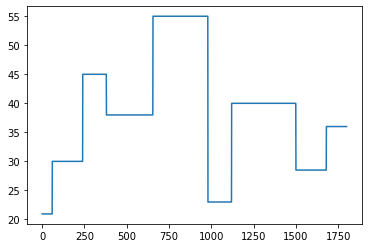

In [6]:
plt.plot(Tsp)
#plt.plot(Tsp2)

In [7]:
#########################################################
# Initialize Model
#########################################################
# remote=True for MacOS
# Code modified to output only 1 heater control
m = GEKKO(name='tclab-mpc',remote=False)

# 60 second time horizon, steps of 3 sec
m.time = np.linspace(0,60,21)

# Parameters
# Parameter estimation see: https://apmonitor.com/do/index.php/Main/TCLabE
U = m.FV(value=8.132,name='u')
Us = m.FV(value=16.675,name='us')
tau = m.FV(value=25.0,name='tau')
alpha1 = m.FV(value=0.0102)   # W / % heater
alpha2 = m.FV(value=0.0045) # W / % heater
Ta = m.Param(value=23.0+273.15)     # K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann


# Manipulated variables
Q1 = m.MV(value=0)
Q1.STATUS = 1  # use to control temperature
Q1.FSTATUS = 0 # no feedback measurement
Q1.LOWER = 0.0
Q1.UPPER = 100.0
Q1.DMAX = 40.0
Q1.COST = 0.0
Q1.DCOST = 0.0

# Controlled variable
TC1 = m.CV(value=T10)
TC1.STATUS = 1     # minimize error with setpoint range
TC1.FSTATUS = 1    # receive measurement
TC1.TR_INIT = 1    # reference trajectory
TC1.TAU = 10       # time constant for response

# State variables
Q2 = m.MV(value=0)
Q2.STATUS = 0  # use to control temperature
Q2.FSTATUS = 0 # no feedback measurement

TC2 = m.CV(value=T20)
TC2.STATUS = 0     # minimize error with setpoint range
TC2.FSTATUS = 1    # receive measurement

TH1 = m.SV(value=T10)
TH2 = m.SV(value=T20)

# Heater temperatures
T1i = m.Intermediate(TH1+273.15)
T2i = m.Intermediate(TH2+273.15)

# Heat transfer between two heaters
Q_C12 = m.Intermediate(Us*As*(T2i-T1i)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2i**4-T1i**4)) # Radiative

# Semi-fundamental correlations (energy balances)
m.Equation(TH1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1i) \
                    + eps * sigma * A * (Ta**4 - T1i**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(TH2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2i) \
                    + eps * sigma * A * (Ta**4 - T2i**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

# Empirical correlations (lag equations to emulate conduction)
m.Equation(tau * TC1.dt() == -TC1 + TH1)
m.Equation(tau * TC2.dt() == -TC2 + TH2)

# Global Options
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 3 # Collocation nodes
m.options.SOLVER  = 3 # 1=APOPT, 3=IPOPT
##################################################################

In [8]:
# TCLab simulation parameters
speedx = 10
TCLab = tclab.setup(connected=False, speedup=speedx)

In [9]:
# Control loop
with TCLab() as lab:
    lhist = Historian(lab.sources)
    
    # Start temperatures
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    start_time = time.time()
    prev_time = start_time
    t_run_mpc = []
    
    for t in tclab.clock(loops_rand):
        
        ###############################
        ### MPC CONTROLLER          ###
        ###############################
        #Cambiar Tsp según se quiera
        Tsp1_value = Tsp[min(loops_rand-1,int(round(t)))]
        
        TC1.MEAS = lab.T1
        DT = 0.1
        TC1.SPHI = Tsp1_value + DT
        TC1.SPLO = Tsp1_value - DT
        # solve MPC
        t0_mpc = time.time()
        m.solve(disp=False)
        tf_mpc = time.time()
        t_run_mpc.append(tf_mpc-t0_mpc)
        # test for successful solution
        if (m.options.APPSTATUS==1):
            # retrieve the first Q value
            Q1s_in = Q1.NEWVAL
        else:
            # not successful, set heater to zero
            Q1s_in = 0        
            Q2s_in = 0        

        lab.Q1(Q1s_in)
        
        lhist.update(t)
            
    lab.Q1(0)
    lab.Q2(0)
    print('Shutting down')

end_time = time.time()
print(end_time-start_time, 'seconds')

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.63 °C
Shutting down
TCLab Model disconnected successfully.
1550.993307352066 seconds


In [11]:
# Save the data to use in training
t, T1, T2, Q1, Q2 = lhist.fields

ttot = np.arange(loops_rand)
Tsp1_df = np.interp(t,ttot,Tsp)

mydata = np.array([t,Tsp1_df,T1,T2,Q1,Q2])

In [12]:
df = pd.DataFrame(data=mydata.T, columns=['t','Tsp','T1','T2','Q1','Q2'])

In [55]:
df.to_csv('MPC_datafortraining.csv',index=True)